In [2]:
# Full example for my blog post at:
# https://danijar.com/building-variational-auto-encoders-in-tensorflow/

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from IPython import display
from tensorflow.examples.tutorials.mnist import input_data

tfd = tf.contrib.distributions

seaborn.reset_orig()
plt.style.use('default')

In [2]:
def make_encoder(data, code_size):
  x = tf.layers.flatten(data)
  x = tf.layers.dense(x, 200, tf.nn.relu)
  x = tf.layers.dense(x, 200, tf.nn.relu)
  loc = tf.layers.dense(x, code_size)
  scale = tf.layers.dense(x, code_size, tf.nn.softplus)
  return tfd.MultivariateNormalDiag(loc, scale)


def make_prior(code_size):
  loc = tf.zeros(code_size)
  scale = tf.ones(code_size)
  return tfd.MultivariateNormalDiag(loc, scale)


def make_decoder(code, data_shape):
  x = code
  x = tf.layers.dense(x, 200, tf.nn.relu)
  x = tf.layers.dense(x, 200, tf.nn.relu)
  logit = tf.layers.dense(x, np.prod(data_shape))
  logit = tf.reshape(logit, [-1] + data_shape)
  return tfd.Independent(tfd.Bernoulli(logit), 2)


def plot_online(epoch, codes, labels, samples, size=1):
    
  fig, ax = plt.subplots(
      ncols=1 + len(samples), figsize=((1 + len(samples)) * size, size))
  no_ticks = dict(left='off', bottom='off', labelleft='off', labelbottom='off')
    
  ax[0].set_ylabel('Epoch {}'.format(epoch))
  ax[0].scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
  ax[0].set_aspect('equal')
  ax[0].set_xlim(codes.min() - .1, codes.max() + .1)
  ax[0].set_ylim(codes.min() - .1, codes.max() + .1)
  ax[0].tick_params(axis='both', which='both', **no_ticks)
    
  for index, sample in enumerate(samples):
    ax[1 + index].imshow(sample, cmap='gray')
    ax[1 + index].tick_params(axis='both', which='both', **no_ticks)
    
  display.display(fig)
  plt.close()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Epoch 0 elbo -543.9179


/home/nathan/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


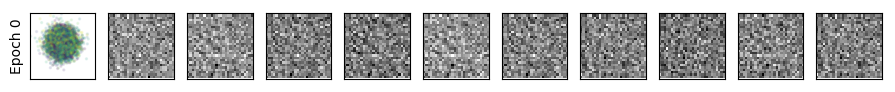

Epoch 1 elbo -168.72534


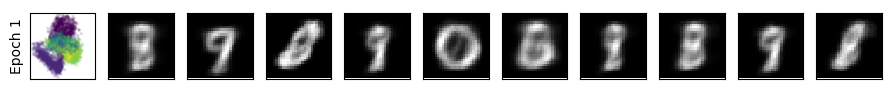

Epoch 2 elbo -161.6873


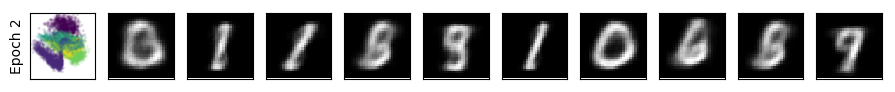

Epoch 3 elbo -157.35097


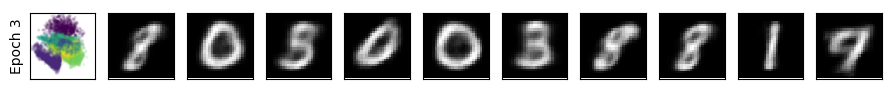

Epoch 4 elbo -155.10828


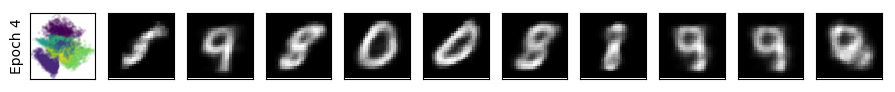

Epoch 5 elbo -152.2487


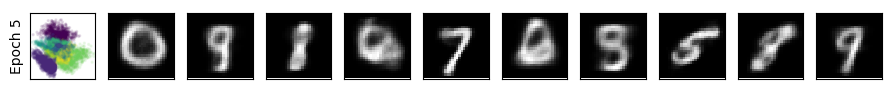

Epoch 6 elbo -150.84697


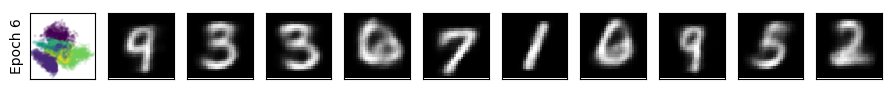

Epoch 7 elbo -149.12848


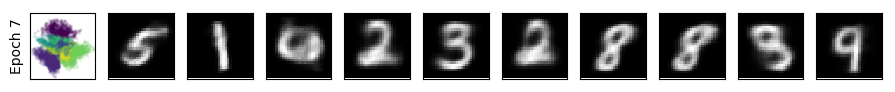

Epoch 8 elbo -148.28384


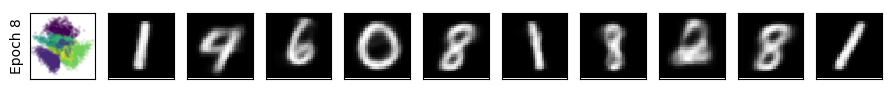

Epoch 9 elbo -147.2678


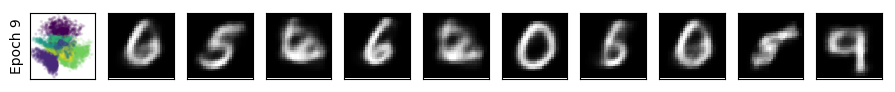

Epoch 10 elbo -146.47404


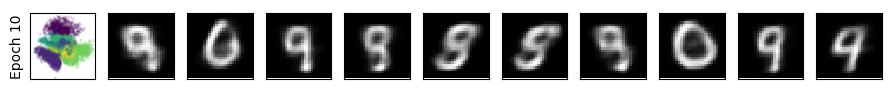

Epoch 11 elbo -145.77951


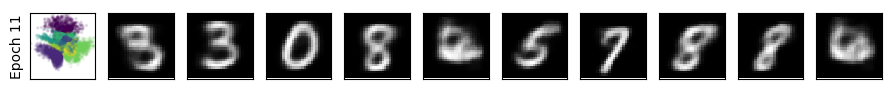

Epoch 12 elbo -145.80984


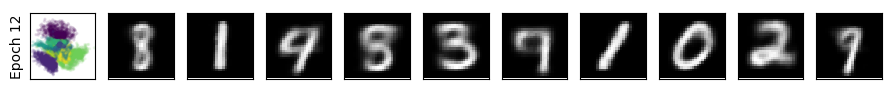

Epoch 13 elbo -144.54822


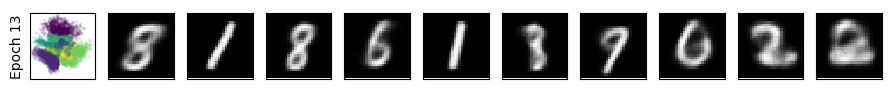

Epoch 14 elbo -144.54283


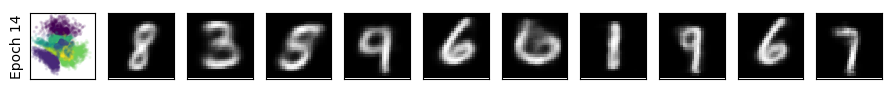

Epoch 15 elbo -143.83618


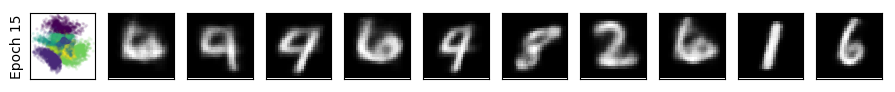

Epoch 16 elbo -143.59482


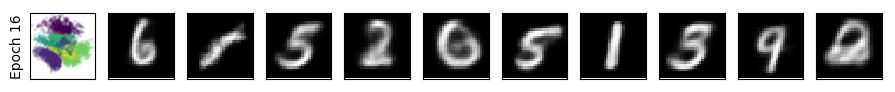

Epoch 17 elbo -143.79625


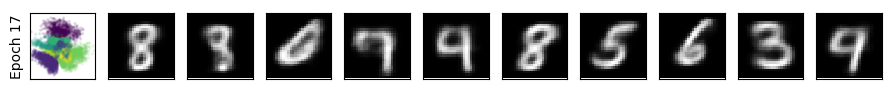

Epoch 18 elbo -143.28983


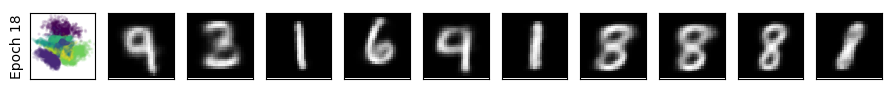

Epoch 19 elbo -142.90082


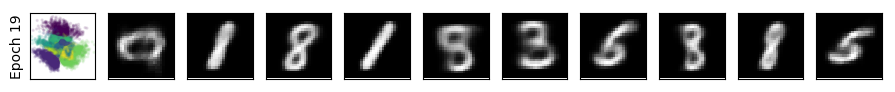

In [2]:
data = tf.placeholder(tf.float32, [None, 28, 28])

make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

# Define the model.
prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

# Define the loss.
likelihood = make_decoder(code, [28, 28]).log_prob(data)

divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

samples = make_decoder(prior.sample(10), [28, 28]).mean()

mnist = input_data.read_data_sets('MNIST_data/')

with tf.Session() as sess:
    
  sess.run(tf.global_variables_initializer())

  for epoch in range(20):
        
    feed = {data: mnist.test.images.reshape([-1, 28, 28])}
    (test_elbo, test_codes, test_samples) = sess.run([elbo, code, samples], feed)
    
    print('Epoch', epoch, 'elbo', test_elbo)
    
    plot_online(epoch, test_codes, mnist.test.labels, test_samples)
    
    for _ in range(600):
      feed = {data: mnist.train.next_batch(100)[0].reshape([-1, 28, 28])}
      sess.run(optimize, feed)